In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier #Second is for data size >10k. CLASSIFICATION.
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor #as above. REGRESSION.
# import lightgbm

In [11]:
df = pd.read_csv('train_top_20k.csv')
df = df[df.columns.tolist()[1:]] #Drops the duplicated index values in the first column.
df.dropna(subset=['target'], inplace=True)
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


#### Some basic notes on the column definitions, units, etc:
- imbalance_size is defined as the "amount unmatched at the current reference price (in USD)"
- imbalance_buy_sell_flag gives the DIRECTION of the auction imbalance
- reference_price is the price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized (in that order). **What does this mean exactly?**

In [12]:
weight_arr = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
]
stock_id_list = np.arange(200)
weights_df = pd.DataFrame({'stock_id':stock_id_list, 'weight':weight_arr})
df = df.merge(weights_df, how='left', on='stock_id')
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,weight
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0,0.004
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1,0.001
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2,0.002
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3,0.006
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4,0.004


In [13]:
#Cell to explore the above loaded df if needed without disturbing what is below.

# df[~df['far_price'].isna()]

# test = df.groupby(['stock_id']).rolling(3)['bid_price'].mean().fillna(method='bfill')
# df['ewmas_3'] = np.zeros(len(df))
# df['ewmas_3'] = np.where(df['stock_id']==0, test, df['ewmas_3'])
# print(df.groupby('stock_id').rolling(1)['bid_price'].mean()[0].head(20))
# test.head(20)

In [26]:
# df[df['stock_id']==0].head(20)

#### Next cell will be adding some BASIC features to the data as manual (domain-specific) augmentation. 
TBD: how to incorporate formal kernel methods if that is of interest.

In [14]:
import warnings
warnings.filterwarnings('ignore')

#Add basics like categorical target (for classification tree), book skew + other simple data transforms.
df['book_skew'] = np.log(df['bid_size']/df['ask_size'])
df['target_cat'] = np.where(df['target'] < 0, -1, np.where(df['target'] > 0, 1, 0)) #should we make this binary?

#Add some moving-average style transformations of important variables.
ewma_windows = [3,5,10]
ewma_cols = ['imbalance_size', 'book_skew', 'bid_price', 'ask_price']
for w in ewma_windows:
    for col in ewma_cols:
        df[f'ewmas_{col}_{w}'] = np.zeros(len(df))
        for id in df['stock_id'].unique():
            ma = df.groupby(['stock_id']).rolling(w)[col].mean().fillna(method='bfill').loc[id] #This is a little sketchy, maybe worth changing?
            # df[f'ewmas_{col}_{w}'] = np.where(df['stock_id']==id, ma, df[f'ewmas_{col}_{w}'])
            df[f'ewmas_{col}_{w}'][ma.index] = ma
        # print(f'ewmas_{col}_{w}', np.sum(df[f'ewmas_{col}_{w}']==0))



# df[['book_skew', 'ewmas_book_skew_5', 'bid_price', 'ask_price', 'ewmas_bid_price_5', 'ewmas_ask_price_5', "stock_id", 'date_id']].head(20)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,weight,book_skew,target_cat
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0,0.004,1.965899,-1
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1,0.001,-1.852115,-1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2,0.002,0.692252,-1
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3,0.006,-5.328091,-1
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4,0.004,3.636964,-1


In [15]:
#Derive the train/test params for our toy model.
print(df.time_id.unique()) #gonna use up to 40 for training and the rest for testing

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]


In [16]:
#Define the train-test split.
X_train = df[df['time_id'] <=40].drop(columns=['target', 'target_cat'])
X_train = X_train.fillna(1e-9) #For imputing NaN values. Does this value make a big difference to performance?
X_test = df[df['time_id'] >40].drop(columns=['target', 'target_cat'])
X_test = X_test.fillna(1e-9) #See above.
print("Xtrain length", len(X_train)); print("Xtest length", len(X_test))
y_train = df[df['time_id'] <=40]['target']
y_test = df[df['time_id'] >40]['target']

#Filter for final feature set.
features = [c for c in df.columns if not c in ['stock_id','date_id','seconds_in_bucket','target_cat', 'target']]
print("Number of features used: ", len(features))
X_train = X_train[features]
X_test = X_test[features]

X_train.head()

Xtrain length 7831
Xtest length 2169
Number of features used:  27


,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,...,ewmas_bid_price_3,ewmas_ask_price_3,ewmas_imbalance_size_5,ewmas_book_skew_5,ewmas_bid_price_5,ewmas_ask_price_5,ewmas_imbalance_size_10,ewmas_book_skew_10,ewmas_bid_price_10,ewmas_ask_price_10
0,3180602.69,1,0.999812,13380276.64,1.000000e-09,1.000000e-09,0.999812,60651.50,1.000026,8493.03,...,0.999812,0.999990,1.659625e+06,0.017416,0.999941,1.000112,1.437813e+06,0.020892,1.000134,1.000283
1,166603.91,-1,0.999896,1642214.25,1.000000e-09,1.000000e-09,0.999896,3233.04,1.000660,20605.09,...,0.999896,1.000660,1.653446e+05,-0.858154,0.999896,1.000519,1.587247e+05,-0.806547,0.999826,1.000325
2,302879.87,-1,0.999561,1819368.03,1.000000e-09,1.000000e-09,0.999403,37956.00,1.000298,18995.00,...,0.999333,1.000158,1.993880e+05,2.490127,0.999277,1.000056,1.845573e+05,1.395419,0.999298,1.000088
3,11917682.27,-1,1.000171,18389745.62,1.000000e-09,1.000000e-09,0.999999,2324.90,1.000214,479032.40,...,0.999956,1.000128,1.115098e+07,-0.573014,0.999956,1.000154,1.110936e+07,0.087768,0.999995,1.000193
4,447549.96,-1,0.999532,17860614.95,1.000000e-09,1.000000e-09,0.999394,16485.54,1.000016,434.10,...,0.999809,1.000200,4.318647e+05,1.203269,0.999823,1.000154,4.393167e+05,-0.269244,0.999850,1.000133


In [35]:
#Fit classifier.
interesting_cols = ['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap', 'time_id', 'weight', 'book_skew']
clf = GradientBoostingRegressor(loss='absolute_error', learning_rate=0.05, n_estimators=1000, verbose=1, random_state=42)
clf.fit(X_train[interesting_cols], y_train)

      Iter       Train Loss   Remaining Time 
         1           5.9358           52.99s
         2           5.9188           42.90s
         3           5.9031           39.27s
         4           5.8887           36.88s
         5           5.8772           35.14s
         6           5.8648           34.07s
         7           5.8532           33.51s
         8           5.8439           32.89s
         9           5.8339           32.42s
        10           5.8252           31.97s
        20           5.7546           30.10s
        30           5.7048           29.06s
        40           5.6673           28.40s
        50           5.6302           28.06s
        60           5.5950           27.62s
        70           5.5568           27.38s
        80           5.5391           26.98s
        90           5.5297           26.57s
       100           5.5084           26.20s
       200           5.2975           22.87s
       300           5.1933           19.95s
       40

GradientBoostingRegressor(learning_rate=0.05, loss='absolute_error',
                          n_estimators=1000, random_state=42, verbose=1)

In [37]:
#Run prediction.
y_pred = clf.predict(X_test[interesting_cols])
prediction_mae = np.linalg.norm(y_pred-y_test,ord=1)/len(y_pred)
print(prediction_mae)

4.828092399714304


<Figure size 5000x10000 with 0 Axes>

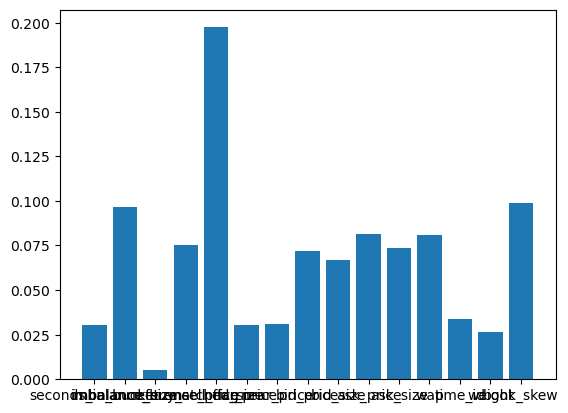

<Figure size 5000x10000 with 0 Axes>

In [42]:
plt.bar(clf.feature_names_in_, height=clf.feature_importances_)
plt.figure(figsize=(50,100))